In [1]:
import json
import cv2
import numpy as np
import os
from shapely.geometry import Polygon, MultiPolygon
from collections import deque
import matplotlib.pyplot as plt

In [2]:
def bfs_split_mask(mask):
    rows, cols, *_ = mask.shape
    binary_mask = np.zeros((rows, cols))
    binary_mask[mask[:, :, 3] > 0] = 1
    visited = np.zeros_like(binary_mask, dtype=bool)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    regions = []

    for r in range(rows):
        for c in range(cols):
            if binary_mask[r, c] == 1 and not visited[r, c]:
                region = np.zeros_like(binary_mask, dtype=np.uint8)
                queue = deque([(r, c)])
                visited[r, c] = True

                while queue:
                    x, y = queue.popleft()
                    region[x, y] = 1

                    for dx, dy in directions:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < rows and 0 <= ny < cols and binary_mask[nx, ny] == 1 and not visited[nx, ny]:
                            queue.append((nx, ny))
                            visited[nx, ny] = True

                regions.append(region)

    return regions

def regions_to_polygons(regions):
    polygons = []
    for region in regions:
        contours, _ = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            coords = [(point[0][0], point[0][1]) for point in contour]

            if len(coords) < 3:
                continue

            polygon = Polygon(coords)

            if polygon.is_valid and polygon.area > 0:
                polygons.append(polygon)
            elif polygon.buffer(0).is_valid:
                polygon = polygon.buffer(0)
                if isinstance(polygon, MultiPolygon):
                    for polygon_split in list(polygon.geoms):
                        polygons.append(polygon_split)
                else:
                    polygons.append(polygon.buffer(0))

    return polygons

### Load homography info

In [28]:
info_path = r'C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\homography_info'
with open(os.path.join(info_path, 'info.json'), 'r') as info_file:
    homography_info = json.load(info_file)

H1 = np.load(os.path.join(info_path, homography_info['cameras']['weti1']['filename']))
H2 = np.load(os.path.join(info_path, homography_info['cameras']['weti2']['filename']))
H12 = np.load(os.path.join(info_path, homography_info['cameras']['weti1_weti2']['filename']))

homography = {
    'weti1': H1,
    'weti2': H2,
    'weti1_weti2': H12
}

### Load masks

In [4]:
camera_ids = ['weti1', 'weti2']
# loading masks
camera_masks = {
    cid: {
        'allowed': cv2.imread(os.path.join(info_path, f"allowed_{cid}.png"), cv2.IMREAD_UNCHANGED),
        'forbidden': cv2.imread(os.path.join(info_path, f"forbidden_{cid}.png"), cv2.IMREAD_UNCHANGED)
    } for cid in camera_ids
}

# crop to top left corner
for cid in camera_ids:
    offx, offy = homography_info['cameras'][cid]['offset']
    camera_masks[cid]['allowed'] = camera_masks[cid]['allowed'][offy:, offx:]
    camera_masks[cid]['forbidden'] = camera_masks[cid]['forbidden'][offy:, offx:]

### Transform masks to polygons

In [47]:
def transform_point(point, H):
    point = np.array([*point, 1])
    transformed_point = np.dot(H, point)
    transformed_point /= transformed_point[2]
    return transformed_point[:2]

def transform_polygon(polygon, H, scale=1):
    transformed_points = [transform_point(p, H) * scale for p in np.array(polygon.exterior.coords)]
    return Polygon(transformed_points)

In [48]:
# masks to separate regions
camera_polygons = {
    cid: {
        'allowed': regions_to_polygons(bfs_split_mask(camera_masks[cid]['allowed'])),
        'forbidden': regions_to_polygons(bfs_split_mask(camera_masks[cid]['forbidden']))
    } for cid in camera_ids
}

In [49]:
# regions to polygons
camera_polygons_transformed = {
    cid: {
        'allowed': [transform_polygon(poly, homography[cid]) for poly in camera_polygons[cid]['allowed']],
        'forbidden': [transform_polygon(poly, homography[cid]) for poly in camera_polygons[cid]['forbidden']]
    } for cid in camera_ids
}

In [50]:
# merging two cameras
# weti1 to weti2
cid = 'weti1'
hid = 'weti1_weti2'
camera_polygons_transformed[cid] = {
    'allowed': [transform_polygon(poly, homography[hid]) for poly in camera_polygons_transformed[cid]['allowed']],
    'forbidden': [transform_polygon(poly, homography[hid]) for poly in camera_polygons_transformed[cid]['forbidden']]
}

15.219966765357906
34.791867482814915
13.619467527807641
1.0454349017651907
22.09982518613497
21.87174197340538
8.54781838594865
20.486959772750605
30.98787051721493
13.652098332668416
8.694869388785444
4.314778841620073
15.015706104985508
65.78672583741483
0.611576824127883
0.017987019828508404
0.288219162291921
0.4985817660183851
11.252978202655179
17.50091125249004
61.194934998301896
74.1053153871185
8.642621607099981
219.84149858572505
1.7784068028348907
186.04056863924876


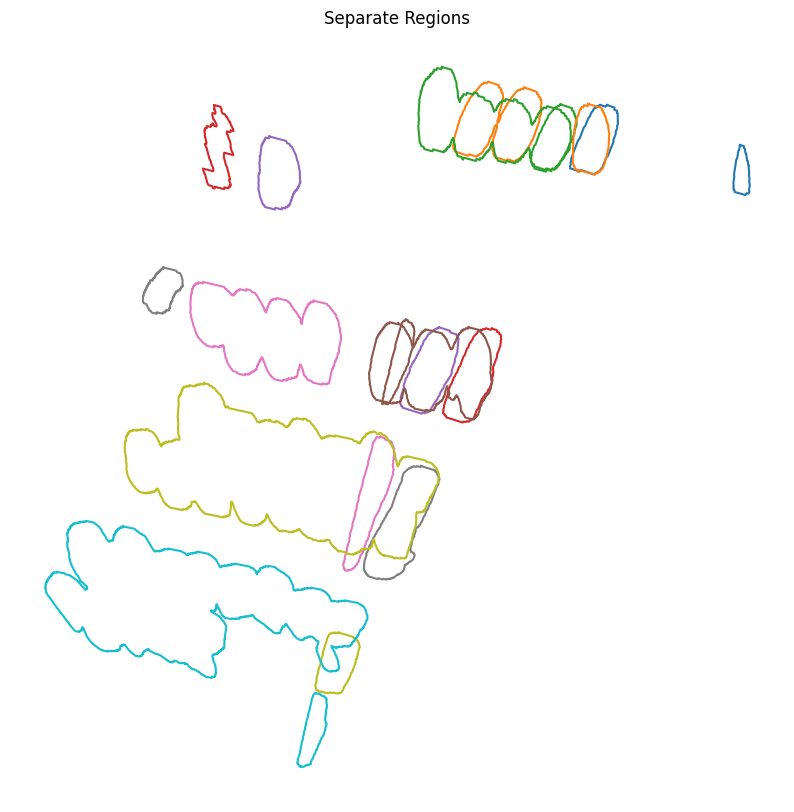

In [ ]:
area_threshold = 4
fig, ax = plt.subplots(figsize=(10, 10))

for poly in camera_polygons_transformed['weti1']['allowed']:
    print(poly.area)
    if poly.area > area_threshold:
        ax.plot(*poly.exterior.xy)
for poly in camera_polygons_transformed['weti2']['allowed']:
    print(poly.area)
    if poly.area > area_threshold:
        ax.plot(*poly.exterior.xy)

ax.set_title("Separate Regions")
plt.axis("off")
plt.title('allowed merged')
plt.show()

42.956493919323634
374.3090137781298
91.68907591811663
113.68929993344385
0.07489388140103415
0.05697881704804973
0.04620309379665461
0.02074909262571769
0.08320433289789156
0.009666547207457485
0.012858180636979149
0.009663249074110453
0.0015197304856126252
0.024261109423228414
0.39154437623738925
45.89782811466552
724.7354868622637
1.180482963066224
0.13261541529443857
0.41306649950140606
0.010328771865327824
0.09142437292003744
0.26458041404670785
0.009464787322995327
0.23699200350212055
0.0035797923642066328
0.1434490026929747
0.025688351813751852
0.2753561474448453
0.03549442404923984
0.01267176095135425
0.1850586287198229
0.03394040950195464
0.014180082655349823
0.7212114477671872
0.06870158304502429
0.01454560774090772
0.005283983889527684
0.002879884349963659
0.05932997942702403
0.005597860432395825
70.22800931773698
42.308425001013276
0.006695342045069078
30.490034245088314
0.24403085686047646
0.07266811978654512
0.03876144462469891
0.09433440663559682
0.0024259233618897052
0.

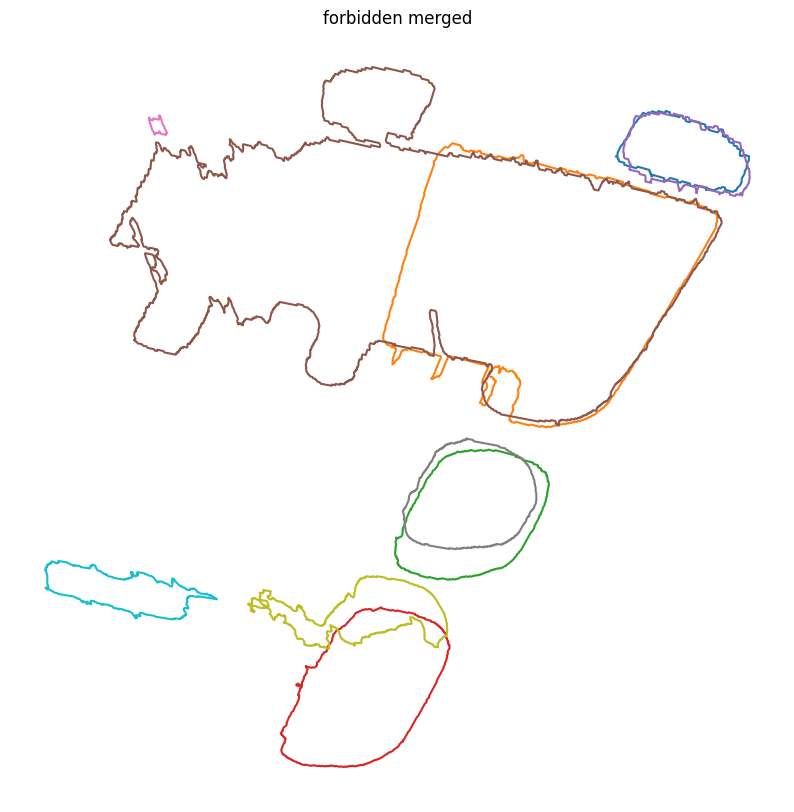

In [55]:
area_f_threshold = 1
fig, ax = plt.subplots(figsize=(10, 10))

for poly in camera_polygons_transformed['weti1']['forbidden']:
    print(poly.area)
    if poly.area > area_f_threshold:
        ax.plot(*poly.exterior.xy)
for poly in camera_polygons_transformed['weti2']['forbidden']:
    print(poly.area)
    if poly.area > area_f_threshold:
        ax.plot(*poly.exterior.xy)

ax.set_title("Separate Regions")
plt.axis("off")
plt.title('forbidden merged')
plt.show()